In [1]:
create_updated_files = True
create_report = False
install_pandas_profiling = False
from_drive = False

In [2]:
if from_drive:
    from google.colab import drive
    drive.mount('/content/drive')

In [3]:
if install_pandas_profiling:
    !pip install pandas-profiling==2.9.0

In [4]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

import warnings
warnings.filterwarnings("ignore")

if create_report:
    from pandas_profiling import ProfileReport

In [5]:
df1 = pd.read_csv("air_quality_merged.csv")
df2 = pd.read_csv("meteorological_data_merged.csv")

In [6]:
df2.head()

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,V01,H02,V02,H03,V03,H04,V04,H05,V05,H06,V06,H07,V07,H08,V08,H09,V09,H10,V10,H11,V11,H12,V12,H13,V13,H14,V14,H15,V15,H16,V16,H17,V17,H18,V18,H19,V19,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
0,28,79,102,81,28079102_81_98,2019,1,1,0.65,V,0.95,V,0.87,V,0.73,V,0.57,V,0.57,V,0.80,V,0.85,V,0.90,V,0.73,V,0.85,V,1.02,V,0.62,V,0.45,V,0.77,V,0.35,V,0.98,V,0.47,V,0.37,V,0.43,V,0.58,V,0.38,V,0.67,V,0.18,V
1,28,79,102,81,28079102_81_98,2019,1,2,0.50,V,0.95,V,0.60,V,0.73,V,1.62,V,1.42,V,0.48,V,2.42,V,0.75,V,1.35,V,1.40,V,0.98,V,0.83,V,0.47,V,0.52,V,0.50,V,0.57,V,0.80,V,0.88,V,0.53,V,1.13,V,2.02,V,3.48,V,2.82,V
2,28,79,102,81,28079102_81_98,2019,1,3,2.22,V,2.53,V,2.20,V,2.43,V,1.90,V,2.18,V,2.13,V,2.17,V,1.12,V,1.23,V,1.02,V,0.93,V,1.23,V,1.33,V,0.82,V,1.12,V,0.77,V,0.43,V,0.25,V,0.50,V,2.02,V,1.33,V,0.83,V,0.67,V
3,28,79,102,81,28079102_81_98,2019,1,4,0.87,V,0.77,V,0.87,V,0.92,V,0.65,V,0.47,V,0.70,V,0.23,V,0.50,V,0.78,V,1.03,V,0.87,V,0.45,V,0.50,V,0.48,V,0.28,V,0.68,V,0.47,V,0.40,V,0.13,V,0.58,V,0.92,V,0.20,V,0.33,V
4,28,79,102,81,28079102_81_98,2019,1,5,0.57,V,1.82,V,1.65,V,0.55,V,0.58,V,0.60,V,0.68,V,0.42,V,0.52,V,0.23,V,0.42,V,0.92,V,0.28,V,0.63,V,0.68,V,0.87,V,0.60,V,0.45,V,0.60,V,0.47,V,0.32,V,0.30,V,0.23,V,0.45,V


### Dropping columns with invalid data (N)

In [7]:
len(df1), len(df2)

(146959, 89950)

In [8]:
def drop_invalid_data(_df: pd.DataFrame):
    numbers = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10",
           "11", "12", "13", "14", "15", "16", "17", "18", "19", "20",
           "21", "22", "23", "24"]
           
    for num in numbers:
        _df = _df[_df["V" + num] == "V"]
    return _df

In [9]:
df1 = drop_invalid_data(df1)
df2 = drop_invalid_data(df2)

We have decided to drop this rows because there are just a few of them with invalid data:

In [10]:
len(df1), len(df2)

(130223, 85116)

In [11]:
df1 = df1[[col for col in df1.columns if col[0] != "V"]]
df2 = df2[[col for col in df2.columns if col[0] != "V"]]

### Adding a datetime column

In [12]:
df1 = df1.rename({"ANO": "year", "MES": "month", "DIA": "day"}, axis=1)
df2 = df2.rename({"ANO": "year", "MES": "month", "DIA": "day"}, axis=1)

In [13]:
df1["FECHA"] = pd.to_datetime(df1[["year", "month", "day"]])
df2["FECHA"] = pd.to_datetime(df2[["year", "month", "day"]])

In [14]:
df1.sort_values("FECHA", inplace=True)
df2.sort_values("FECHA", inplace=True)

In [15]:
df1.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True)

In [16]:
df1 = df1.rename({"year": "ANO", "month": "MES", "day": "DIA"}, axis=1)
df2 = df2.rename({"year": "ANO", "month": "MES", "day": "DIA"}, axis=1)

In [17]:
df1.head(3)

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,H02,H03,H04,H05,H06,H07,H08,H09,H10,H11,H12,H13,H14,H15,H16,H17,H18,H19,H20,H21,H22,H23,H24,FECHA
0,28,79,4,1,28079004_1_38,2019,1,1,23.0,17.0,19.0,14.0,13.0,12.0,11.0,12.0,11.0,12.0,16.0,25.0,23.0,22.0,19.0,18.0,17.0,18.0,23.0,28.0,26.0,24.0,19.0,16.0,2019-01-01
1,28,79,11,30,28079011_30_59,2019,1,1,1.3,1.2,1.0,0.8,0.6,0.5,0.6,0.4,0.4,0.4,0.4,0.3,0.3,0.3,0.6,0.6,0.6,0.6,1.8,1.7,1.3,2.0,3.0,1.9,2019-01-01
2,28,79,56,6,28079056_6_48,2019,1,1,0.6,0.8,0.7,0.6,0.6,0.6,0.6,0.5,0.5,0.5,0.5,0.5,0.4,0.3,0.3,0.3,0.3,0.6,0.8,1.8,1.2,1.0,0.8,0.6,2019-01-01


### PROVINCIA and MUNICIPIO have constant values 28 and 79 respectively, so we can drop them 

In [18]:
df1 = df1.drop(["PROVINCIA", "MUNICIPIO"], axis=1)
df2 = df2.drop(["PROVINCIA", "MUNICIPIO"], axis=1)

### Changing the values of MAGNITUD to a more readable information

In [19]:
met_dict = {80:"UV Radiation(mW/m^2)",81:"Wind Velocity(m/s)",82:"Wind Direction",83:"Temperature(ºC)",86:"Relative Humidity(%)",87:"Barometric Pressure(mb)",88:"Solar Radiation(W/m^2)",89:"Precipitation(l/m^2)"}
air_dict = {1:"SO_2(µg/m^3)",6:"CO(µg/m^3)",7:"NO(µg/m^3)",8:"NO_2",9:"PM2.5(µg/m^3)",10:"PM10(µg/m^3)",12:"NOx(µg/m^3)",14:"O_3(µg/m^3)",20:"TOL(µg/m^3)",30:"BEN(µg/m^3)",35:"EBE(µg/m^3)",37:"MXY(µg/m^3)",38:"PXY(µg/m^3)",39:"OXY(µg/m^3)",42:"TCH(mg/m^3)",43:"CH_4(mg/m^3)",44:"NMHC(mg/m^3)"}
df1.MAGNITUD = df1.MAGNITUD.map(air_dict)
df2.MAGNITUD = df2.MAGNITUD.map(met_dict)

In [20]:
df1.head(3)

,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,H02,H03,H04,H05,H06,H07,H08,H09,H10,H11,H12,H13,H14,H15,H16,H17,H18,H19,H20,H21,H22,H23,H24,FECHA
0,4,SO_2(µg/m^3),28079004_1_38,2019,1,1,23.0,17.0,19.0,14.0,13.0,12.0,11.0,12.0,11.0,12.0,16.0,25.0,23.0,22.0,19.0,18.0,17.0,18.0,23.0,28.0,26.0,24.0,19.0,16.0,2019-01-01
1,11,BEN(µg/m^3),28079011_30_59,2019,1,1,1.3,1.2,1.0,0.8,0.6,0.5,0.6,0.4,0.4,0.4,0.4,0.3,0.3,0.3,0.6,0.6,0.6,0.6,1.8,1.7,1.3,2.0,3.0,1.9,2019-01-01
2,56,CO(µg/m^3),28079056_6_48,2019,1,1,0.6,0.8,0.7,0.6,0.6,0.6,0.6,0.5,0.5,0.5,0.5,0.5,0.4,0.3,0.3,0.3,0.3,0.6,0.8,1.8,1.2,1.0,0.8,0.6,2019-01-01


### Adding CALLE column

Using the station code we have to assign the corresponding address which can be found in [interpretacion_calidad_del_aire](https://bit.ly/3czGpCF) and [interpretacion_de_datos_meteorologicos](
https://bit.ly/32eEtNM). The station code starts with 28079 and it is followed by the ESTACION number (with 3 digits: e.g. 4 -> 004). It can also be found in the prefix of PUNTO_MUESTREO.



In [21]:
calle_dict={1:"Paseo Recoletos", 2:"Glorieta Carlos V", 3: "Plaza del Carmen", 35: "Plaza del Carmen", 4:"Plaza de España", 5:"Barrio del Pilar", 39:"Barrio del Pilar", 6:"Plaza Doctor Marañón", 7:"Plaza Mayor de Salamanca", 8:"Escuelas Aguirre", 9:"Plaza Luca de Tena", 10: "Cuatro Caminos", 38: "Cuatro Caminos", 11:"Avenida Ramón y Cajal", 12:"Plaza Manuel Becerra", 13:"Vallecas", 40:"Vallecas", 14:"Plaza Fernández Ladreda", 15:"Plaza Castilla", 50:"Plaza Castilla", 16: "Arturo Soria", 17:"Villaverde Alto", 18: "Farolillo", 19: "Huerta Castañeda", 20:"Moratalaz", 36:"Moratalaz", 102:"JMD Moratalaz", 21:"Plaza Cristo Rey", 22:"Paseo Pontones", 23: "Alcalá", 24:"Casa de Campo", 25:"Santa Eugenia", 26:"Urbanización Embajada", 55:"Urbanización Embajada", 27:"Barajas", 47:"Méndez Álvaro", 48:"Paseo de la Castellana", 49:"Retiro", 54:"Ensanche de Vallecas", 56:"Plaza Elíptica", 57:"Sanchinarro", 58:"El Pardo", 59:"Parque Juan Carlos I", 86:"Tres Olivos", 60:"Tres Olivos", 103: "JMD Villaverde", 104: "EDAR La China", 106:"Centro Municipal de Acústica", 107:"JMD Hortaleza", 108: "Peñagrande", 109:"JMD Chamberí", 110:"JMD Centro", 111:"JMD Chamartin", 112:"JMD Vallecas 1", 113:"JMD Vallecas 2", 114:"Martadero 1", 115:"Martadero 2"}

In [22]:
df1["CALLE"] = df1["ESTACION"].map(calle_dict)
df2["CALLE"] = df2["ESTACION"].map(calle_dict)
df1.head(10)

,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,H02,H03,H04,H05,H06,H07,H08,H09,H10,H11,H12,H13,H14,H15,H16,H17,H18,H19,H20,H21,H22,H23,H24,FECHA,CALLE
0,4,SO_2(µg/m^3),28079004_1_38,2019,1,1,23.00,17.00,19.00,14.00,13.00,12.00,11.00,12.00,11.00,12.00,16.00,25.00,23.00,22.00,19.00,18.00,17.00,18.00,23.00,28.00,26.00,24.00,19.00,16.00,2019-01-01,Plaza de España
1,11,BEN(µg/m^3),28079011_30_59,2019,1,1,1.30,1.20,1.00,0.80,0.60,0.50,0.60,0.40,0.40,0.40,0.40,0.30,0.30,0.30,0.60,0.60,0.60,0.60,1.80,1.70,1.30,2.00,3.00,1.90,2019-01-01,Avenida Ramón y Cajal
2,56,CO(µg/m^3),28079056_6_48,2019,1,1,0.60,0.80,0.70,0.60,0.60,0.60,0.60,0.50,0.50,0.50,0.50,0.50,0.40,0.30,0.30,0.30,0.30,0.60,0.80,1.80,1.20,1.00,0.80,0.60,2019-01-01,Plaza Elíptica
3,11,EBE(µg/m^3),28079011_35_59,2019,1,1,0.40,0.40,0.40,0.30,0.20,0.10,0.20,0.10,0.10,0.20,0.10,0.10,0.10,0.10,0.20,0.30,0.30,0.30,0.90,1.20,0.60,0.70,1.00,0.80,2019-01-01,Avenida Ramón y Cajal
4,55,NMHC(mg/m^3),28079055_44_2,2019,1,1,0.15,0.15,0.15,0.37,0.19,0.17,0.34,0.20,0.16,0.25,0.16,0.18,0.16,0.15,0.17,0.19,0.16,0.15,0.27,0.34,0.31,0.30,0.21,0.20,2019-01-01,Urbanización Embajada
5,16,CO(µg/m^3),28079016_6_48,2019,1,1,0.60,0.50,0.80,0.40,0.40,0.30,0.40,0.40,0.30,0.30,0.20,0.20,0.30,0.40,0.50,0.50,0.40,0.40,0.80,1.60,1.60,1.60,1.30,0.90,2019-01-01,Arturo Soria
6,55,CH_4(mg/m^3),28079055_43_2,2019,1,1,1.48,1.47,1.44,2.01,1.57,1.49,2.07,1.59,1.45,1.84,1.49,1.51,1.41,1.38,1.43,1.44,1.39,1.68,2.21,1.89,1.95,1.82,1.68,1.52,2019-01-01,Urbanización Embajada
7,16,NO(µg/m^3),28079016_7_8,2019,1,1,18.00,10.00,18.00,11.00,7.00,1.00,3.00,9.00,3.00,3.00,4.00,5.00,8.00,10.00,15.00,17.00,17.00,26.00,81.00,201.00,157.00,190.00,156.00,52.00,2019-01-01,Arturo Soria
8,55,TCH(mg/m^3),28079055_42_2,2019,1,1,1.63,1.62,1.58,2.38,1.76,1.66,2.41,1.80,1.62,2.09,1.64,1.69,1.57,1.53,1.60,1.63,1.55,1.82,2.48,2.23,2.25,2.11,1.89,1.71,2019-01-01,Urbanización Embajada
9,16,NO_2,28079016_8_8,2019,1,1,53.00,44.00,54.00,43.00,42.00,20.00,34.00,45.00,35.00,19.00,16.00,20.00,23.00,32.00,44.00,54.00,60.00,75.00,95.00,130.00,121.00,125.00,120.00,80.00,2019-01-01,Arturo Soria


### Add MEDIDA column


In [23]:
df1["MEDIDA"] = df1["PUNTO_MUESTREO"] + df1["FECHA"].dt.strftime("_%y_%m_%d")
df2["MEDIDA"] = df2["PUNTO_MUESTREO"] + df2["FECHA"].dt.strftime("_%y_%m_%d")

In [24]:
df1.head()

,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,H02,H03,H04,H05,H06,H07,H08,H09,H10,H11,H12,H13,H14,H15,H16,H17,H18,H19,H20,H21,H22,H23,H24,FECHA,CALLE,MEDIDA
0,4,SO_2(µg/m^3),28079004_1_38,2019,1,1,23.00,17.00,19.00,14.00,13.00,12.00,11.00,12.0,11.00,12.00,16.00,25.00,23.00,22.00,19.00,18.00,17.00,18.00,23.00,28.00,26.00,24.0,19.00,16.0,2019-01-01,Plaza de España,28079004_1_38_19_01_01
1,11,BEN(µg/m^3),28079011_30_59,2019,1,1,1.30,1.20,1.00,0.80,0.60,0.50,0.60,0.4,0.40,0.40,0.40,0.30,0.30,0.30,0.60,0.60,0.60,0.60,1.80,1.70,1.30,2.0,3.00,1.9,2019-01-01,Avenida Ramón y Cajal,28079011_30_59_19_01_01
2,56,CO(µg/m^3),28079056_6_48,2019,1,1,0.60,0.80,0.70,0.60,0.60,0.60,0.60,0.5,0.50,0.50,0.50,0.50,0.40,0.30,0.30,0.30,0.30,0.60,0.80,1.80,1.20,1.0,0.80,0.6,2019-01-01,Plaza Elíptica,28079056_6_48_19_01_01
3,11,EBE(µg/m^3),28079011_35_59,2019,1,1,0.40,0.40,0.40,0.30,0.20,0.10,0.20,0.1,0.10,0.20,0.10,0.10,0.10,0.10,0.20,0.30,0.30,0.30,0.90,1.20,0.60,0.7,1.00,0.8,2019-01-01,Avenida Ramón y Cajal,28079011_35_59_19_01_01
4,55,NMHC(mg/m^3),28079055_44_2,2019,1,1,0.15,0.15,0.15,0.37,0.19,0.17,0.34,0.2,0.16,0.25,0.16,0.18,0.16,0.15,0.17,0.19,0.16,0.15,0.27,0.34,0.31,0.3,0.21,0.2,2019-01-01,Urbanización Embajada,28079055_44_2_19_01_01


### Add MEDIA_DIA column (mean of the day)

In [25]:
df1["MEDIA_DIA"] = df1.loc[:,"H01": "H24"].mean(axis=1)
df2["MEDIA_DIA"] = df1.loc[:,"H01": "H24"].mean(axis=1)

In [26]:
df2.head()

,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,H02,H03,H04,H05,H06,H07,H08,H09,H10,H11,H12,H13,H14,H15,H16,H17,H18,H19,H20,H21,H22,H23,H24,FECHA,CALLE,MEDIDA,MEDIA_DIA
0,102,Wind Velocity(m/s),28079102_81_98,2019,1,1,0.65,0.95,0.87,0.73,0.57,0.57,0.80,0.85,0.90,0.73,0.85,1.02,0.62,0.45,0.77,0.35,0.98,0.47,0.37,0.43,0.58,0.38,0.67,0.18,2019-01-01,JMD Moratalaz,28079102_81_98_19_01_01,18.250000
1,106,Barometric Pressure(mb),28079106_87_98,2019,1,1,960.00,960.00,960.00,960.00,960.00,959.00,959.00,960.00,959.00,960.00,960.00,960.00,960.00,959.00,959.00,959.00,959.00,959.00,959.00,959.00,960.00,959.00,959.00,960.00,2019-01-01,Centro Municipal de Acústica,28079106_87_98_19_01_01,0.941667
2,106,Solar Radiation(W/m^2),28079106_88_98,2019,1,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.00,122.00,275.00,349.00,417.00,429.00,379.00,282.00,149.00,23.00,0.00,0.00,0.00,0.00,0.00,0.00,2019-01-01,Centro Municipal de Acústica,28079106_88_98_19_01_01,0.641667
3,106,Precipitation(l/m^2),28079106_89_98,2019,1,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2019-01-01,Centro Municipal de Acústica,28079106_89_98_19_01_01,0.379167
4,107,Wind Velocity(m/s),28079107_81_98,2019,1,1,0.45,0.35,0.28,0.40,0.30,0.37,0.52,0.33,0.35,0.57,0.58,0.42,0.52,0.28,0.35,0.38,0.38,0.27,0.00,0.00,0.00,0.30,0.40,0.02,2019-01-01,JMD Hortaleza,28079107_81_98_19_01_01,0.211667


### Drop H columns

In [27]:
df1.drop(['H01', 'H02', 'H03', 'H04', 'H05', 'H06', 'H07', 'H08', 'H09', 'H10', 'H11', 'H12', 
          'H13', 'H14',	'H15', 'H16', 'H17', 'H18',	'H19', 'H20', 'H21', 'H22', 'H23', 'H24'], axis=1, inplace=True)
df2.drop(['H01', 'H02', 'H03', 'H04', 'H05', 'H06', 'H07', 'H08', 'H09', 'H10', 'H11', 'H12', 
          'H13', 'H14',	'H15', 'H16', 'H17', 'H18',	'H19', 'H20', 'H21', 'H22', 'H23', 'H24'], axis=1, inplace=True)

In [28]:
df1.rename(columns={'ESTACION':'ControlStation','MAGNITUD':'magnitude', 'PUNTO_MUESTREO':'samplingPoint', 'ANO':'year', 'MES':'month', 'DIA':'day', 'FECHA':'date', 'CALLE':'street', 'MEDIDA':'Measurement', 'MEDIA_DIA':'value'},inplace=True)

In [29]:
df2.rename(columns={'ESTACION':'ControlStation','MAGNITUD':'magnitude', 'PUNTO_MUESTREO':'samplingPoint', 'ANO':'year', 'MES':'month', 'DIA':'day', 'FECHA':'date', 'CALLE':'street', 'MEDIDA':'Measurement', 'MEDIA_DIA':'value'},inplace=True)

In [30]:
df1.head()

,ControlStation,magnitude,samplingPoint,year,month,day,date,street,Measurement,value
0,4,SO_2(µg/m^3),28079004_1_38,2019,1,1,2019-01-01,Plaza de España,28079004_1_38_19_01_01,18.250000
1,11,BEN(µg/m^3),28079011_30_59,2019,1,1,2019-01-01,Avenida Ramón y Cajal,28079011_30_59_19_01_01,0.941667
2,56,CO(µg/m^3),28079056_6_48,2019,1,1,2019-01-01,Plaza Elíptica,28079056_6_48_19_01_01,0.641667
3,11,EBE(µg/m^3),28079011_35_59,2019,1,1,2019-01-01,Avenida Ramón y Cajal,28079011_35_59_19_01_01,0.379167
4,55,NMHC(mg/m^3),28079055_44_2,2019,1,1,2019-01-01,Urbanización Embajada,28079055_44_2_19_01_01,0.211667


In [31]:
df2.head()

,ControlStation,magnitude,samplingPoint,year,month,day,date,street,Measurement,value
0,102,Wind Velocity(m/s),28079102_81_98,2019,1,1,2019-01-01,JMD Moratalaz,28079102_81_98_19_01_01,18.250000
1,106,Barometric Pressure(mb),28079106_87_98,2019,1,1,2019-01-01,Centro Municipal de Acústica,28079106_87_98_19_01_01,0.941667
2,106,Solar Radiation(W/m^2),28079106_88_98,2019,1,1,2019-01-01,Centro Municipal de Acústica,28079106_88_98_19_01_01,0.641667
3,106,Precipitation(l/m^2),28079106_89_98,2019,1,1,2019-01-01,Centro Municipal de Acústica,28079106_89_98_19_01_01,0.379167
4,107,Wind Velocity(m/s),28079107_81_98,2019,1,1,2019-01-01,JMD Hortaleza,28079107_81_98_19_01_01,0.211667


### Drop samplingPoint column

In [33]:
del df1["samplingPoint"]
del df2["samplingPoint"]

### Observations

Some stations measure both air quality and meteorological data:

In [34]:
set(df1.ControlStation.unique()) & set(df2.magnitude.unique())

set()

Measurement has unique values but for some reason it has duplicate values

In [35]:
df1.Measurement.value_counts()

28079050_10_47_19_09_24    2
28079035_12_8_19_09_02     2
28079008_43_2_19_09_02     2
28079024_35_59_20_09_11    2
28079055_43_2_19_09_29     2
                          ..
28079016_6_48_19_01_28     1
28079047_12_8_21_01_31     1
28079016_12_8_20_01_20     1
28079011_12_8_19_08_20     1
28079018_6_48_21_04_03     1
Name: Measurement, Length: 121988, dtype: int64

In [36]:
df1[df1.Measurement == "28079024_14_6_19_09_26"]

,ControlStation,magnitude,year,month,day,date,street,Measurement,value
39966,24,O_3(µg/m^3),2019,9,26,2019-09-26,Casa de Campo,28079024_14_6_19_09_26,40.118333
40015,24,O_3(µg/m^3),2019,9,26,2019-09-26,Casa de Campo,28079024_14_6_19_09_26,40.118333


### Drop duplicate rows

In [37]:
df1.drop_duplicates(inplace=True)
df2.drop_duplicates(inplace=True)

In [38]:
df1.Measurement.value_counts()

28079055_8_8_19_02_26      1
28079024_10_47_19_12_11    1
28079055_35_59_19_04_04    1
28079024_10_47_21_08_10    1
28079011_30_59_19_12_20    1
                          ..
28079038_10_47_20_07_16    1
28079027_12_8_21_08_01     1
28079011_20_59_19_09_11    1
28079040_12_8_20_02_04     1
28079018_6_48_21_04_03     1
Name: Measurement, Length: 121988, dtype: int64

### Creating an html report

In [40]:
if create_report:
    profile1 = ProfileReport(df1, title="Air Quality Data Report")

    profile1.to_file("air_quality_report.html")

In [41]:
if create_report:
    profile1 = ProfileReport(df2, title="Meteorological Data Report")

    profile1.to_file("meteorological_data_report.html")

### load dataframes into a csv file

In [42]:
df1

,ControlStation,magnitude,year,month,day,date,street,Measurement,value
0,4,SO_2(µg/m^3),2019,1,1,2019-01-01,Plaza de España,28079004_1_38_19_01_01,18.250000
1,11,BEN(µg/m^3),2019,1,1,2019-01-01,Avenida Ramón y Cajal,28079011_30_59_19_01_01,0.941667
2,56,CO(µg/m^3),2019,1,1,2019-01-01,Plaza Elíptica,28079056_6_48_19_01_01,0.641667
3,11,EBE(µg/m^3),2019,1,1,2019-01-01,Avenida Ramón y Cajal,28079011_35_59_19_01_01,0.379167
4,55,NMHC(mg/m^3),2019,1,1,2019-01-01,Urbanización Embajada,28079055_44_2_19_01_01,0.211667
...,...,...,...,...,...,...,...,...,...
130218,27,NO(µg/m^3),2021,9,30,2021-09-30,Barajas,28079027_7_8_21_09_30,7.250000
130219,38,PM10(µg/m^3),2021,9,30,2021-09-30,Cuatro Caminos,28079038_10_47_21_09_30,16.291667
130220,54,NO_2,2021,9,30,2021-09-30,Ensanche de Vallecas,28079054_8_8_21_09_30,41.666667
130221,38,NO(µg/m^3),2021,9,30,2021-09-30,Cuatro Caminos,28079038_7_8_21_09_30,10.708333


In [43]:
df2

,ControlStation,magnitude,year,month,day,date,street,Measurement,value
0,102,Wind Velocity(m/s),2019,1,1,2019-01-01,JMD Moratalaz,28079102_81_98_19_01_01,18.250000
1,106,Barometric Pressure(mb),2019,1,1,2019-01-01,Centro Municipal de Acústica,28079106_87_98_19_01_01,0.941667
2,106,Solar Radiation(W/m^2),2019,1,1,2019-01-01,Centro Municipal de Acústica,28079106_88_98_19_01_01,0.641667
3,106,Precipitation(l/m^2),2019,1,1,2019-01-01,Centro Municipal de Acústica,28079106_89_98_19_01_01,0.379167
4,107,Wind Velocity(m/s),2019,1,1,2019-01-01,JMD Hortaleza,28079107_81_98_19_01_01,0.211667
...,...,...,...,...,...,...,...,...,...
85111,107,Solar Radiation(W/m^2),2021,9,30,2021-09-30,JMD Hortaleza,28079107_88_98_21_09_30,1.416667
85112,104,Wind Direction,2021,9,30,2021-09-30,EDAR La China,28079104_82_98_21_09_30,1.014167
85113,35,Relative Humidity(%),2021,9,30,2021-09-30,Plaza del Carmen,28079035_86_98_21_09_30,0.200000
85114,108,Wind Velocity(m/s),2021,9,30,2021-09-30,Peñagrande,28079108_81_98_21_09_30,14.875000


In [44]:
if create_updated_files:
    df1.to_csv("air_quality-updated.csv", index=False)
    df2.to_csv("meteorological_data-updated.csv", index=False)

### Figures

In [45]:
plt.style.use("bmh")

In [46]:
df1.magnitude.unique()

array(['SO_2(µg/m^3)', 'BEN(µg/m^3)', 'CO(µg/m^3)', 'EBE(µg/m^3)',
       'NMHC(mg/m^3)', 'CH_4(mg/m^3)', 'NO(µg/m^3)', 'TCH(mg/m^3)',
       'NO_2', 'NOx(µg/m^3)', 'O_3(µg/m^3)', 'TOL(µg/m^3)',
       'PM10(µg/m^3)', 'PM2.5(µg/m^3)'], dtype=object)

In [47]:
dataframes = [df1[df1.magnitude == val][["date", "value"]] for val in df1.magnitude.unique()]

In [48]:
def plot(title, selected_labels: list = None, years=(2019, 2020, 2021), figsize=(10, 6), compare_years=False):

    labels = df1.magnitude.unique()
    selected_labels = labels if selected_labels is None else selected_labels

    fig = plt.figure(figsize=figsize)
    my_axes = fig.add_axes([0,0,1,1])
    my_axes.set_title(title)

    for df, label in zip(dataframes, labels):
        if label in selected_labels:
            if not compare_years:
                temp = df[df1.date.dt.year.isin(years)].groupby("date").mean()
                my_axes.plot(temp.index, temp.value, label=label)
            else:
                for year in years:

                    raise NotImplementedError 

                    # we want to compare the values of each year by day with two different lines
                    # the x-axis is the date and it shows the month, the y-axis is the average of the day

                    temp = df[df1.date.dt.year == year].groupby("date").mean()

                    temp["MONTH_DAY"] = temp.index.dt.strftime("%m-%d")

                    # check if it is a leap year and drop the 29th of February using datetime
                    if year % 4 == 0:
                        print(temp[temp.MONTH_DAY == "02-29"])
                        temp = temp[temp.MONTH_DAY != "02-29"]

                    # my_axes.plot(pd.date_range("01-01", periods=365), temp.MEDIA_DIA, label=label + " " + str(year))

    my_axes.legend(loc=0)
    plt.show()

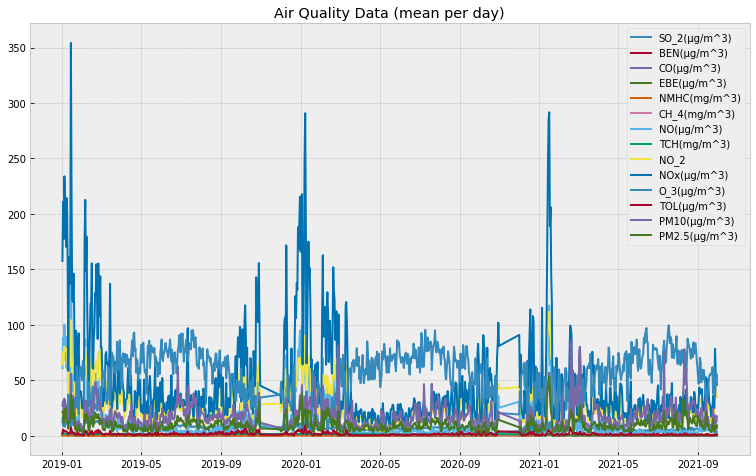

In [49]:
plot("Air Quality Data (mean per day)")

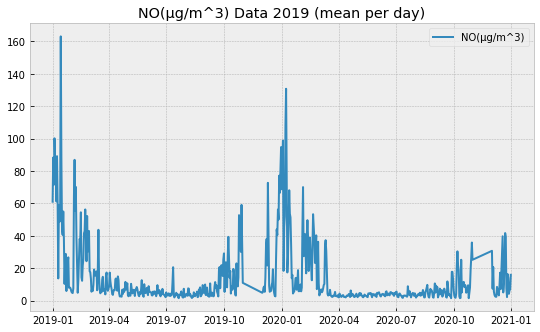

In [50]:
plot("NO(µg/m^3) Data 2019 (mean per day)", ["NO(µg/m^3)"], [2019, 2020], figsize=(7, 4))

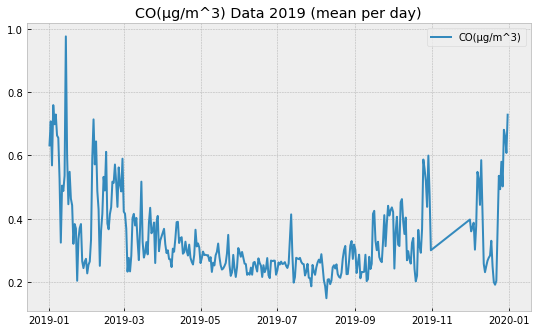

In [51]:
plot("CO(µg/m^3) Data 2019 (mean per day)", ["CO(µg/m^3)"], [2019], figsize=(7, 4))

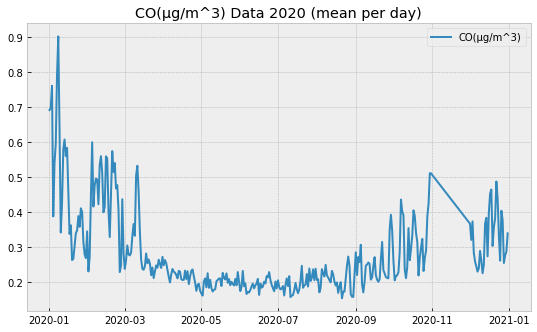

In [52]:
plot("CO(µg/m^3) Data 2020 (mean per day)", ["CO(µg/m^3)"], [2020], figsize=(7, 4))

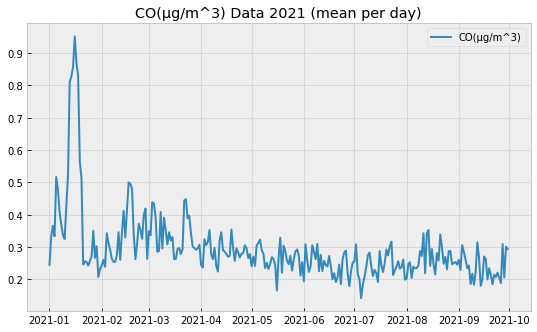

In [53]:
plot("CO(µg/m^3) Data 2021 (mean per day)", ["CO(µg/m^3)"], [2021], figsize=(7, 4))